# Activations, Gradient, and BatchNorm

In [1]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
# retina
%config InlineBackend.figure_format = 'retina'

In [2]:
# read the dataset
words = open('./data/names.txt', 'r').read().splitlines()
print('Number of words:', len(words))

Number of words: 32033


In [3]:
print('First 10 words:', words[:10])

First 10 words: ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [4]:
# build up the dictionary for mapping characters to integers
chars = sorted(list(set(''.join(words))))
print('Number of characters:', len(chars))
# chars to integers
char2int = {c: i+1 for i, c in enumerate(chars)}
# add . as the padding character
char2int['.'] = 0
# integers to chars
int2char = {i: c for c, i in char2int.items()}
# vocabulary size
vocab_size = len(char2int)

Number of characters: 26


In [6]:
print(char2int)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [6]:
# build the dataset
block_size = 3 

def build_dataset(words):
    X, Y = [], []
    for word in words:
        # add . as the padding character to the beginning of the word
        context = [0] * block_size
        for char in word + '.':
            X.append(context)
            Y.append(char2int[char])
            # update the context
            context = context[1:] + [char2int[char]]
    # convert to tensors
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print('X:', X.shape, 'Y:', Y.shape)
    return X, Y

In [7]:
# split the dataset into training and validation sets
# 80%, 10%, 10%
# set the random seed
random.seed(666)
# shuffle the words
random.shuffle(words)
# split the words
train_words = words[:int(0.8*len(words))]
val_words = words[int(0.8*len(words)):int(0.9*len(words))]
test_words = words[int(0.9*len(words)):]

# build the datasets
X_train, Y_train = build_dataset(train_words)
X_val, Y_val = build_dataset(val_words)
X_test, Y_test = build_dataset(test_words)


X: torch.Size([182426, 3]) Y: torch.Size([182426])
X: torch.Size([22807, 3]) Y: torch.Size([22807])
X: torch.Size([22913, 3]) Y: torch.Size([22913])


In [16]:
# build the model
num_embeddings = 10 # dimension of the embedding space
num_hidden = 200 # dimension of the hidden layer 

# set the seed
g_seed = torch.Generator().manual_seed(777)

# initialize the weights
C_emb = torch.randn(vocab_size, num_embeddings, generator=g_seed)
# first layer
W1 = torch.randn(block_size*num_embeddings, num_hidden, generator=g_seed) * (5/3)/((block_size*num_embeddings)**0.5)
b1 = torch.randn(num_hidden, generator=g_seed) * 0.01
# second layer with special initialization
W2 = torch.randn(num_hidden, vocab_size, generator=g_seed) * 0.01
b2 = torch.randn(vocab_size, generator=g_seed) * 0

# add batch normalization parameters
bn_gain = torch.ones(1, num_hidden)
bn_bias = torch.zeros(1, num_hidden)

# add batch normalization mean and variance
bn_mean = torch.zeros(1, num_hidden)
bn_std = torch.ones(1, num_hidden)

parameters = [C_emb, W1, b1, W2, b2, bn_gain, bn_bias]

# print total number of parameters
total_params = sum(p.numel() for p in parameters)
print('Total number of parameters:', total_params)

# initialize the gradients
for p in parameters:
    p.requires_grad = True

Total number of parameters: 12297


In [109]:
print("X_train:", X_train.shape)

X_train: torch.Size([182426, 3])


In [15]:
# define the forward pass that defines the architecture of the model
def forward(X, Y, bn_mean, bn_std, *parameters):
    global bn_mean
    global bn_std
    C_emb, W1, b1, W2, b2, bn_gain, bn_bias = parameters
    # get the embeddings
    # shape of X_emb: (batch_size, block_size, num_embeddings)
    X_emb = C_emb[X]
    # flatten the embeddings
    X_emb = X_emb.view(-1, block_size*num_embeddings)
    # first layer h.shape = (batch_size*num_embeddings, num_hidden)
    hpreact = X_emb @ W1 + b1
    # batch normalization
    bn_mean_i = hpreact.mean(0, keepdim=True)
    bn_std_i = hpreact.std(0, keepdim=True)
    hpreact = bn_gain * (hpreact - bn_mean_i) / bn_std_i + bn_bias

    # update mean and std
    with torch.no_grad():
        bn_mean = 0.999 * bn_mean + 0.001 * bn_mean_i
        bn_std = 0.999 * bn_std + 0.001 * bn_std_i

    h = torch.tanh(hpreact)
    # second layer
    logits = h @ W2 + b2
    # compute the loss
    loss = F.cross_entropy(logits, Y)
    return loss, h, hpreact

SyntaxError: name 'bn_mean' is parameter and global (4273498240.py, line 3)

In [11]:
# train the model
max_steps = 200000
batch_size = 32
loss_history = []

for i in range(max_steps):
    # sample a batch
    idx = torch.randint(len(X_train), (batch_size,))
    X_batch = X_train[idx]
    Y_batch = Y_train[idx]
    # compute the loss
    loss, h, h_prev = forward(X_batch, Y_batch, bn_mean, bn_std, *parameters)
    # zero out the gradients
    for p in parameters:
        p.grad = None
    # backward pass
    loss.backward()
    # update the parameters
    alpha = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= alpha * p.grad
    # append the loss
    loss_history.append(loss.item())
    # print the loss every 1000 steps
    if i % 5000 == 0:
        print(f'Step {i},:::{i/max_steps} done:::; Loss {loss.item():.4f}')

Step 0,:::0.0 done:::; Loss 3.2954
Step 5000,:::0.025 done:::; Loss 2.2894
Step 10000,:::0.05 done:::; Loss 2.3234
Step 15000,:::0.075 done:::; Loss 2.1052
Step 20000,:::0.1 done:::; Loss 2.2394
Step 25000,:::0.125 done:::; Loss 2.2382
Step 30000,:::0.15 done:::; Loss 2.1163
Step 35000,:::0.175 done:::; Loss 2.3609
Step 40000,:::0.2 done:::; Loss 2.0007
Step 45000,:::0.225 done:::; Loss 2.2975
Step 50000,:::0.25 done:::; Loss 2.3012
Step 55000,:::0.275 done:::; Loss 2.3405
Step 60000,:::0.3 done:::; Loss 2.5067
Step 65000,:::0.325 done:::; Loss 2.3386
Step 70000,:::0.35 done:::; Loss 2.3253
Step 75000,:::0.375 done:::; Loss 2.5728
Step 80000,:::0.4 done:::; Loss 2.4208
Step 85000,:::0.425 done:::; Loss 1.9239
Step 90000,:::0.45 done:::; Loss 2.1964
Step 95000,:::0.475 done:::; Loss 2.0282
Step 100000,:::0.5 done:::; Loss 2.1943
Step 105000,:::0.525 done:::; Loss 1.9717
Step 110000,:::0.55 done:::; Loss 2.0468
Step 115000,:::0.575 done:::; Loss 2.0403
Step 120000,:::0.6 done:::; Loss 2.

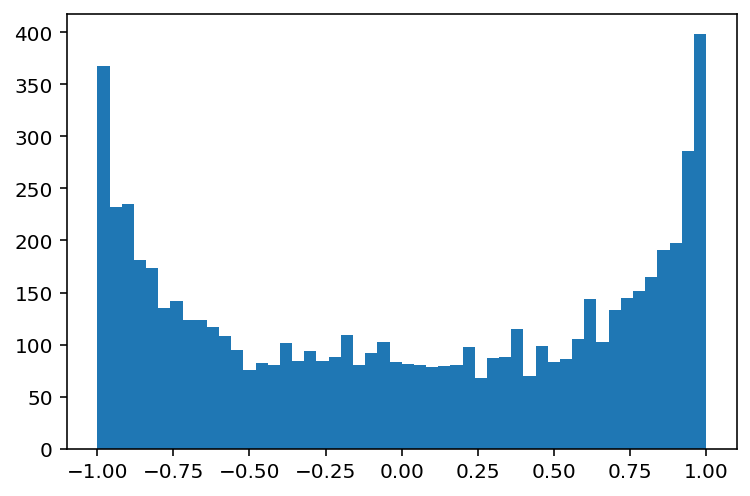

In [85]:
# visualize tanh
plt.hist(h.detach().numpy().flatten(), bins=50);

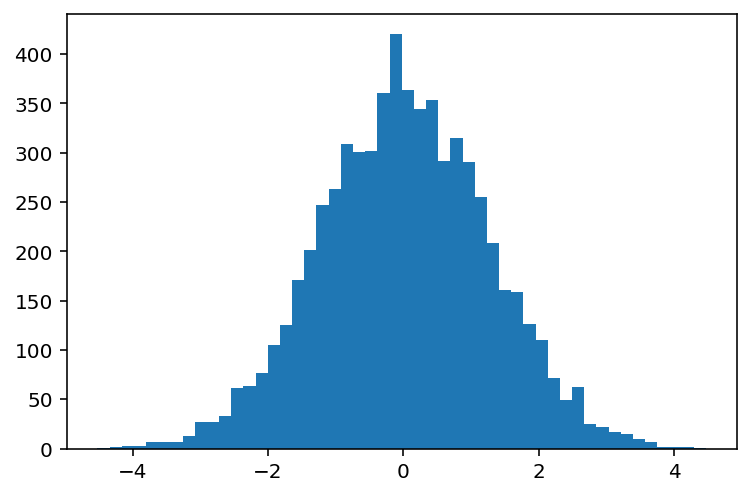

In [86]:
# plot h_prev
plt.hist(h_prev.detach().numpy().flatten(), bins=50);

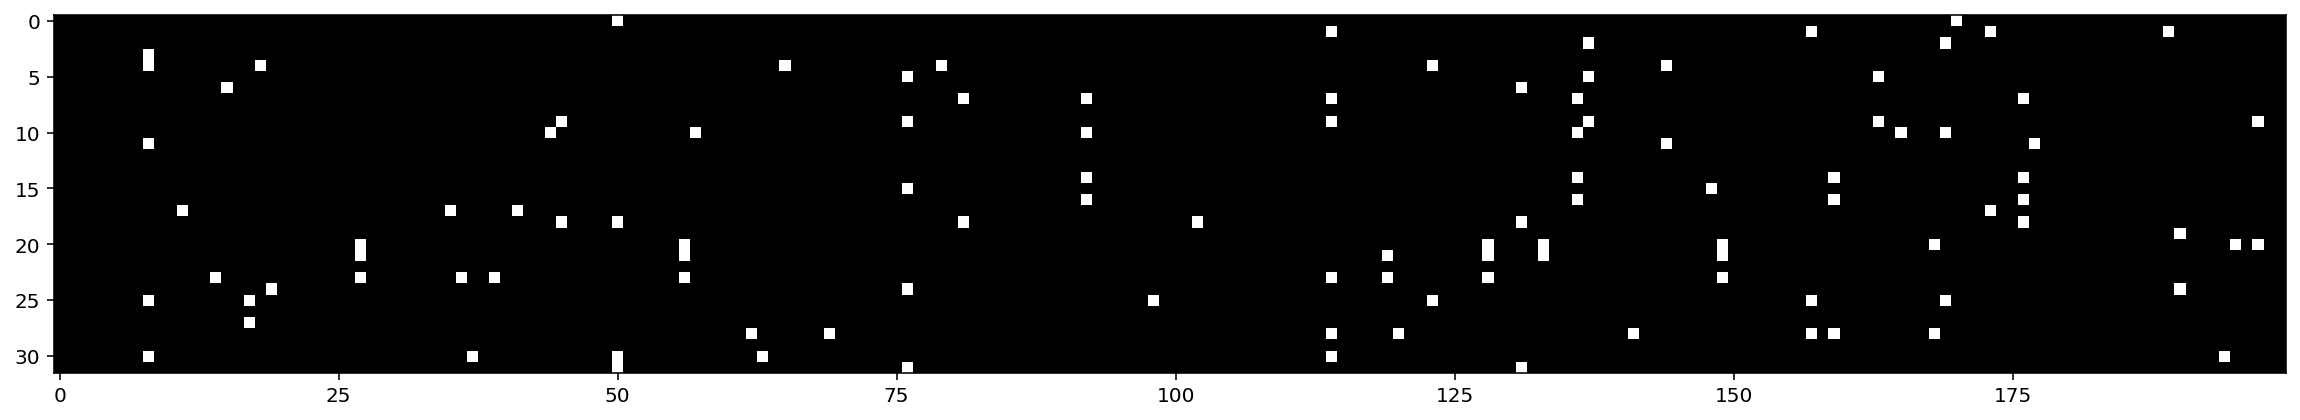

In [87]:
# visualize the tanh neuron
plt.figure(figsize=(20, 10))
plt.imshow(h.detach().numpy() > 0.99, cmap='gray', interpolation='nearest');

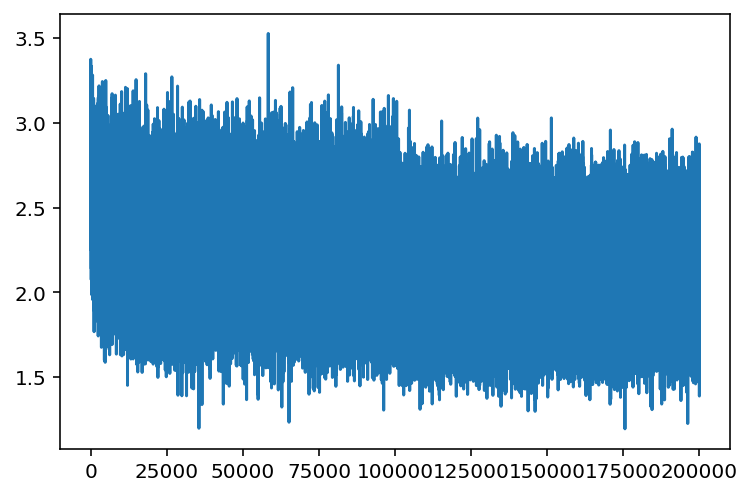

In [52]:
    # plot the loss
plt.plot(loss_history);

In [90]:
@torch.no_grad()
def get_validation_loss(data_key):
    x, y = {
        'train': (X_train, Y_train),
        'val': (X_val, Y_val),
        'test': (X_test, Y_test)
    }[data_key]
    loss, _, _ = forward(x, y, *parameters)

    return loss.item()

In [91]:
# print validation loss
print('Validation loss:', get_validation_loss('val'))
# print test loss
print('Test loss:', get_validation_loss('test'))

Validation loss: 2.1086418628692627
Test loss: 2.0977792739868164


In [101]:
# print validation loss
print('Validation loss:', get_validation_loss('val'))
# print test loss
print('Test loss:', get_validation_loss('test'))

Validation loss: 2.108266592025757
Test loss: 2.0967471599578857


In [24]:
# generate a name
def generate_name():
    # sample a context
    context = [0] * block_size
    # generate a name
    name = []
    while True:
        # convert to a tensor
        X = torch.tensor(context).unsqueeze(0)
        # get the embeddings
        X_emb = C_emb[X]
        # flatten the embeddings
        X_emb = X_emb.view(-1, block_size*num_embeddings)
        # first layer
        h = torch.tanh(X_emb @ W1 + b1)
        # second layer
        logits = h @ W2 + b2
        # sample a character
        p = F.softmax(logits, dim=-1)
        char_idx = torch.multinomial(p, 1).item()
        # stop if we sampled the padding character
        if char_idx == 0:
            break
        # update the context
        context = context[1:] + [char_idx]
        # add the character to the name
        name.append(int2char[char_idx])
    return ''.join(name)

In [103]:
# set seed
torch.manual_seed(888)
for _ in range(20):
    print(generate_name())

kari
desbert
tormiah
taisley
waine
doany
tavyn
marace
bertiyah
damia
bassi
mus
grachi
tyn
ava
rowynd
kalainer
krystana
nya
pacelyn


In [31]:
# uniform initialization
# log likelihood of the uniform distribution
-torch.tensor(1/27.0).log()

tensor(3.2958)

In [39]:
# four dimensional example
information = torch.tensor([5.0, 0.0, 5.0, 5.0])
# likelihood of the uniform distribution
probs = F.softmax(information, dim=0)
# print the probabilities
print('Probabilities:', probs)
log_likelihood = -probs[1].log()
print('Log likelihood of the uniform distribution:', log_likelihood.item())

Probabilities: tensor([0.3326, 0.0022, 0.3326, 0.3326])
Log likelihood of the uniform distribution: 6.100855827331543


In [49]:
# draw from normal distribution
information = torch.randn(4) * 100
print('Information:', information)
# likelihood of the normal distribution
probs = F.softmax(information, dim=0)
# print the probabilities
print('Probabilities:', probs)
log_likelihood = -probs[1].log()
print('Log likelihood of the normal distribution:', log_likelihood.item())

Information: tensor([-70.1930, 215.4527, -95.1327, -64.7722])
Probabilities: tensor([0., 1., 0., 0.])
Log likelihood of the normal distribution: -0.0


x mean -0.0073, std 0.9941
y mean 0.0029, std 0.9826


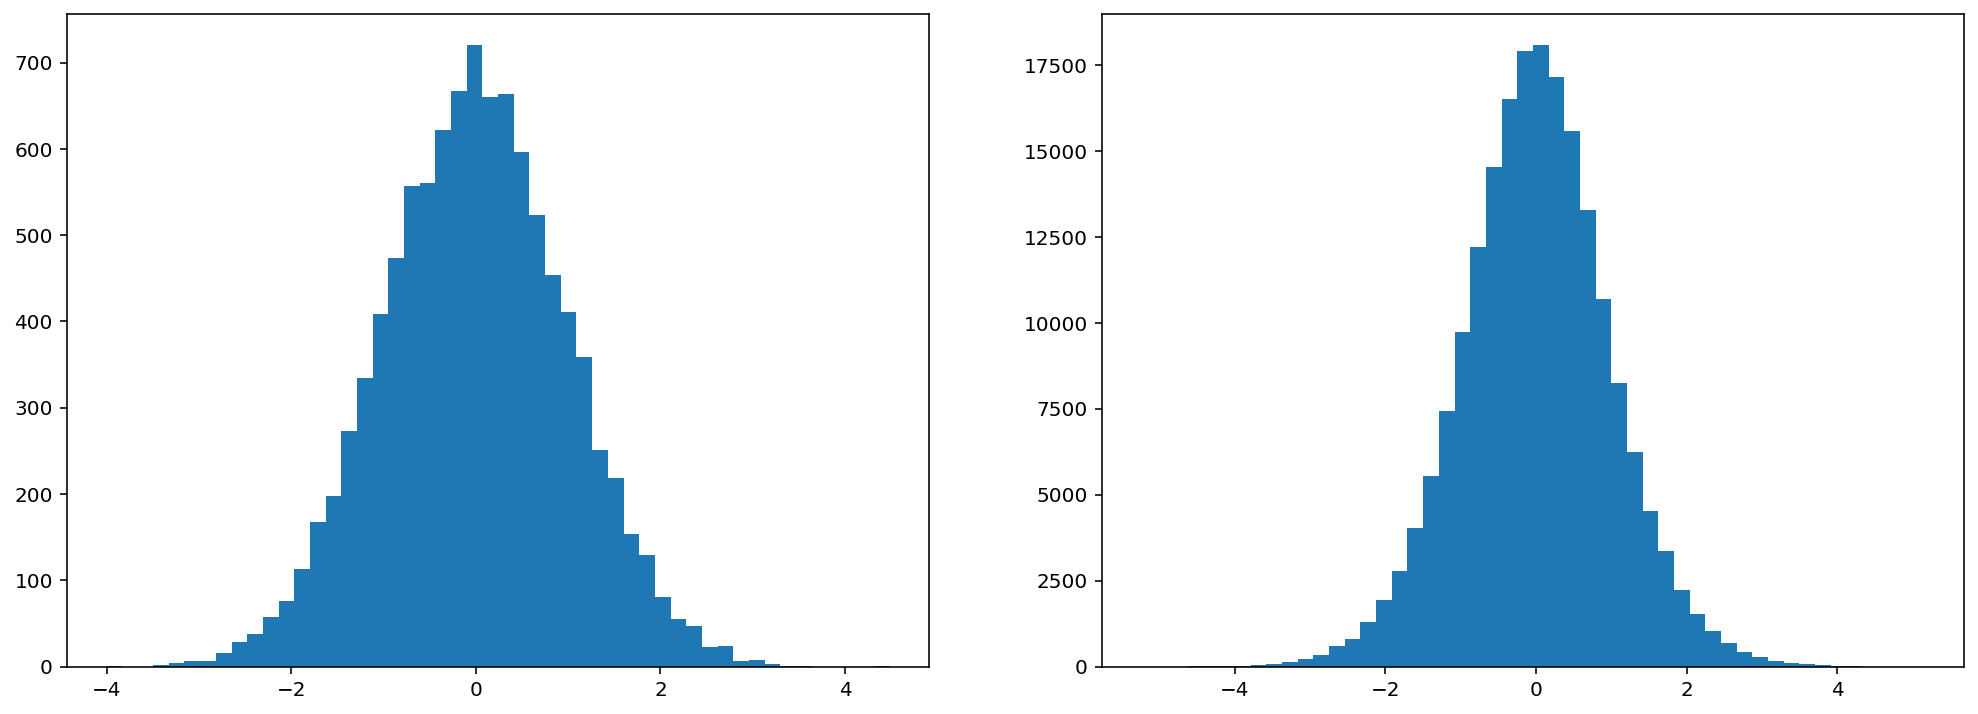

In [98]:
# simulate Gaussian distribution
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(f"x mean {x.mean():.4f}, std {x.std():.4f}")
print(f"y mean {y.mean():.4f}, std {y.std():.4f}")
# plot the histogram
plt.figure(figsize=(17, 6))
plt.subplot(121)
plt.hist(x.view(-1).numpy(), bins=50)
plt.subplot(122)
plt.hist(y.view(-1).numpy(), bins=50);

In [116]:
76820 + 5400 + 47399 + 6892 + 4553 + 7125 + 46775  + 10075 + 166591

371630

In [12]:
# calculate the mean and std
with torch.no_grad():
    X_emb = C_emb[X_train]
    # flatten the embeddings
    X_emb = X_emb.view(-1, block_size*num_embeddings)
    # first layer h.shape = (batch_size*num_embeddings, num_hidden)
    hpreact = X_emb @ W1 + b1
    # batch normalization
    bn_mean_i = hpreact.mean(0, keepdim=True)
    bn_std_i = hpreact.std(0, keepdim=True)

In [13]:
bn_mean_i

tensor([[-0.5999, -0.2863,  0.1880,  1.9770, -0.5020, -1.0678, -0.0434, -1.5514,
          1.4366, -1.3749,  2.4260, -0.2946, -0.9371, -0.7886,  0.5846,  0.1962,
         -1.3571, -1.3490,  3.1128, -0.8529, -1.4431,  3.8503,  1.4003, -1.5956,
         -2.4818, -1.8219, -0.0952,  1.7404,  0.5937,  0.9697, -1.6839,  0.0691,
         -1.1328,  2.0735, -0.3181,  2.9986, -0.1274,  0.1566,  0.5864, -3.1051,
         -1.3661,  0.9826, -3.1271, -0.0450,  0.5239,  0.2491,  0.3319, -0.5167,
          0.1902, -0.8196,  2.9066, -1.2578,  1.6184,  0.2329,  2.1859, -0.0292,
          0.5137, -0.0936, -0.7699,  0.5104,  0.8954, -2.6097,  1.3693,  0.7095,
         -1.2204,  2.3719, -0.1661,  0.7728, -0.6097,  1.9597, -1.0160,  0.8276,
         -3.1536,  0.0446, -0.2335, -2.1531,  1.0503, -1.3153,  1.3497,  2.0388,
         -0.1451, -0.7238,  1.5014,  0.1448,  0.3379, -0.9544,  1.4032,  0.5497,
         -2.0316, -1.8750, -0.0435, -0.1798,  1.1996, -1.2937, -0.7883, -0.3486,
          1.0312,  0.9583,  

In [14]:
bn_mean

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]])